In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
os.listdir('../../input')

['df_ref.csv',
 'dwell_df.csv',
 'dwell_time_agg.csv',
 'item_metadata.csv',
 'reference_first.pkl',
 'submission_popular.csv',
 'test.csv',
 'train.csv']

In [22]:
path = '../../input/'

In [3]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

train['timestamp'] = pd.to_datetime(train['timestamp'],unit='s')
test['timestamp'] = pd.to_datetime(test['timestamp'],unit='s')

In [4]:
df = pd.concat([train, test])
del train, test
df.shape

(19715327, 12)

In [5]:
df = df.sort_values(['user_id','session_id','timestamp']).reset_index(drop = True)
df.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,0001VQMGUI65,466687f1875ee,2018-11-01 12:38:49,1,interaction item deals,3133074,BR,"Brasília, Brazil",desktop,NaN,NaN,NaN
1,0001VQMGUI65,466687f1875ee,2018-11-01 12:39:09,2,interaction item image,3133074,BR,"Brasília, Brazil",desktop,NaN,NaN,NaN
2,0001VQMGUI65,466687f1875ee,2018-11-01 12:39:28,3,clickout item,3133074,BR,"Brasília, Brazil",desktop,NaN,3133074|2653226|477811|164667|1990735|104972|1...,43|55|49|51|44|43|47|47|55|46|31|24|33|75|52|4...
3,0001VQMGUI65,466687f1875ee,2018-11-01 12:39:34,4,interaction item image,3133074,BR,"Brasília, Brazil",desktop,NaN,NaN,NaN
4,0001VQMGUI65,466687f1875ee,2018-11-01 12:39:44,5,interaction item deals,3133074,BR,"Brasília, Brazil",desktop,NaN,NaN,NaN


# no info 제거
- step = 1

In [9]:
no_info = df.groupby(['user_id','session_id'])['step'].last()

In [12]:
no_info = pd.DataFrame(no_info[no_info == 1]).reset_index()
no_info.head(3)

,user_id,session_id,step
0,0004Q49X39PY,9de47d9a66494,1
1,0004Q49X39PY,beea5c27030cb,1
2,0006W0R5A5V8,85501a9f27263,1


In [20]:
df = df[~df.session_id.isin(no_info.session_id)].reset_index(drop = True)
df.shape

(19445848, 12)

In [23]:
reference_first = np.zeros(len(df))
reference_first[0] = 1
check = df['reference'][0]

for i in range(1, len(df)) :
    if check != df['reference'][i] :
        check = df['reference'][i]
        reference_first[i] = 1
        
reference_first = pd.Series(reference_first)
reference_first.to_pickle(path+'reference_first.pkl')

In [24]:
#reference_first = pd.read_pickle(path + 'reference_first.pkl')

In [57]:
dwell_df = pd.DataFrame(columns = ['user_id','reference','dwell_time'])
dwell_df['user_id'] = df[reference_first == 1]['user_id']
dwell_df['reference'] = df[reference_first == 1]['reference']
dwell_df.reset_index(drop = True, inplace = True)

first_time = df[reference_first == 1]['timestamp']
first_time.reset_index(drop = True, inplace = True)

last_time = pd.Series(np.roll(first_time,-1))

dwell_df['dwell_time'] = (last_time - first_time).astype('timedelta64[s]')

In [58]:
dwell_df = dwell_df[dwell_df.dwell_time>0]
dwell_df.shape

(3871806, 3)

In [59]:
def only_number(string):
    """reference에서 숫자인 것만 뽑아 int type으로 변환"""
    try:
        int(string)
        return string
    except ValueError:
        return np.nan

In [60]:
dwell_df.reference = dwell_df.reference.apply(only_number)
dwell_df.dropna(inplace = True)
dwell_df.reset_index(drop = True,inplace = True)
dwell_df.head()

,user_id,reference,dwell_time
0,0001VQMGUI65,3133074,145.0
1,0001VQMGUI65,477811,2.0
2,0001VQMGUI65,3133074,151.0
3,0001VQMGUI65,3133074,90.0
4,0001VQMGUI65,2019467,69.0


In [61]:
dwell_df.shape

(2398726, 3)

In [64]:
# row의 개수가 줄어들었다
# use_id 당 다른 시점에 동일한 reference를 클릭한 경우가 있다는 뜻
dwell_df = pd.DataFrame(dwell_df.groupby(['user_id','reference'])['dwell_time'].sum()).reset_index()
dwell_df.shape

(2005970, 3)

In [76]:
dwell_df.rename(columns = {'dwell_time' : 'dwell_sec'}, inplace = True)
dwell_df['log_dwell_sec'] = np.log1p(dwell_df['dwell_sec'])
dwell_df['dwell_min'] = dwell_df['dwell_sec'] / 60
dwell_df['log_dwell_min'] = np.log1p(dwell_df['dwell_min'])

In [88]:
#dwell_df.to_csv(path + 'dwell_df.csv')

# seconds

In [79]:
dwell_df.dwell_sec.describe()

count    2.005970e+06
mean     4.444397e+04
std      1.144866e+05
min      1.000000e+00
25%      4.400000e+01
50%      1.210000e+02
75%      7.910000e+02
max      2.768116e+06
Name: dwell_sec, dtype: float64

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

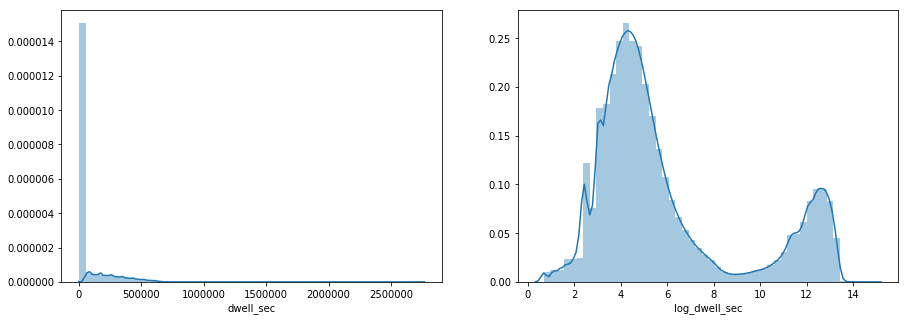

In [86]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (15,5))
sns.distplot(dwell_df.dwell_sec,ax = axs[0])
sns.distplot(dwell_df.log_dwell_sec,ax = axs[1])

# minutes

In [87]:
dwell_df.dwell_min.describe()

count    2.005970e+06
mean     7.407329e+02
std      1.908109e+03
min      1.666667e-02
25%      7.333333e-01
50%      2.016667e+00
75%      1.318333e+01
max      4.613527e+04
Name: dwell_min, dtype: float64

C:\Users\wjssm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


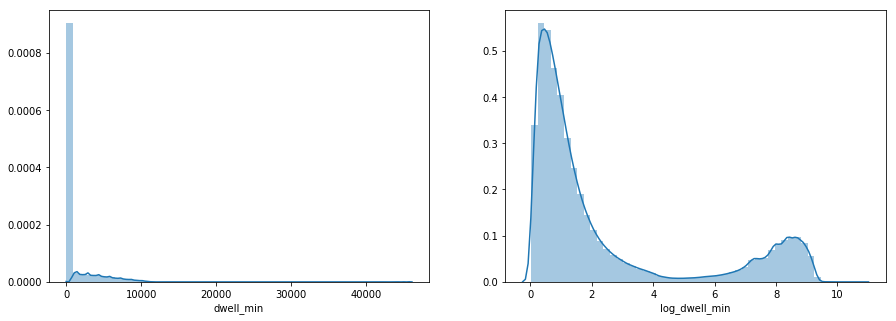

In [89]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (15,5))
sns.distplot(dwell_df.dwell_min,ax = axs[0])
sns.distplot(dwell_df.log_dwell_min,ax = axs[1])